# *Importing Libraries:*

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Flatten
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers.legacy import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

# *Preprocessing:*


In [2]:
path = 'Dataset/'
folders = os.listdir(path)
print(folders)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'D', 'Gh', 'H', 'J', 'L', 'M', 'N', 'P', 'PuV', 'PwD', 'Sad', 'Sin', 'T', 'Taxi', 'V', 'Y']


In [3]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1,)

train_generator = datagen.flow_from_directory(
    path,
    target_size=(128, 128),
    color_mode='rgb',
    batch_size=64,
    shuffle=True,
    class_mode='categorical',
    subset='training')

validation_generator = datagen.flow_from_directory(
    path,
    target_size=(128, 128),
    color_mode='rgb',
    batch_size=64,
    shuffle=True,
    class_mode='categorical',
    subset='validation')

Found 75471 images belonging to 28 classes.
Found 8373 images belonging to 28 classes.


### Show sample:

In [4]:
classes = list(train_generator.class_indices.keys())
img, lable = train_generator.next()
img.shape

(64, 128, 128, 3)

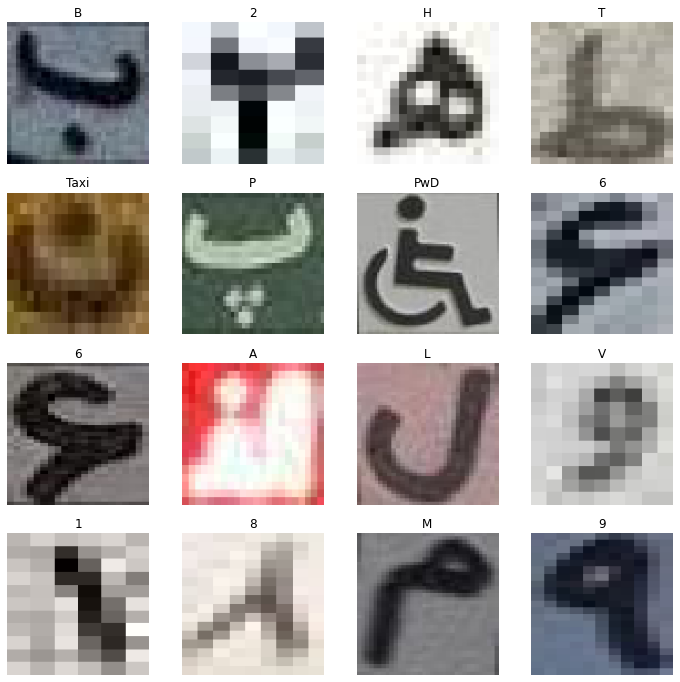

In [5]:
plt.figure(figsize= (12, 12))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(img[i])
    index = np.argmax(lable[i]) 
    class_name = classes[index]
    plt.title(class_name)
    plt.axis('off')
plt.show()

In [6]:
def draw_plot(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    fig, axis = plt.subplots(1, 2, figsize=(15,6))
    axis[0].set_title('Training & validation accuracy', fontsize = 15, fontweight = 'bold')
    axis[0].plot(acc, label='training accuracy', color='darkblue')
    axis[0].plot(val_acc, label='validation accuracy', color='deeppink')
    axis[0].legend()
    axis[1].set_title('Training & validation loss', fontsize = 15, fontweight = 'bold')
    axis[1].plot(loss, label='training loss', color='darkblue')
    axis[1].plot(val_loss, label='validation loss', color='deeppink')
    axis[1].legend()
    
    print("Maximum Accuracy of Training set: {:.8f}\nMinimum Loss of Trainig set: {:.8f}\n".format(np.max(acc), np.min(loss)))
    print("Maximum Accuracy of Validation set: {:.8f}\nMinimum Loss of Validation set: {:.8f}\n".format(np.max(val_acc), np.min(val_loss))) 

def draw_plot_fine(history, history_ft):
    acc = []
    val_acc = []
    loss = []
    val_loss = []

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    acc += history_ft.history['accuracy']
    val_acc += history_ft.history['val_accuracy']

    loss += history_ft.history['loss']
    val_loss += history_ft.history['val_loss']

    plt.figure(figsize=(14, 12))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy', color='darkblue')
    plt.plot(val_acc, label='Validation Accuracy', color='deeppink')
    plt.ylim([0.9, 1.001])
    plt.xlim([-1, 15])
    plt.plot([EPOCHS, EPOCHS], plt.ylim(), label='Start Fine Tuning', color='g')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss', color='darkblue')
    plt.plot(val_loss, label='Validation Loss', color='deeppink')
    plt.ylim([0, 0.3])
    plt.xlim([-1, 15])
    plt.plot([EPOCHS, EPOCHS], plt.ylim(), label='Start Fine Tuning', color='g')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

# *Model Structure:*

In [7]:
# global parameters:
EPOCHS = 10
FINE_TUNE_EPOCHS = 5
IMG_SHAPE = (128, 128, 3)
LR = 1e-3
LR_FT = 1e-5
OPTIMIZER = Adamax(LR)
LOSS = CategoricalCrossentropy()
METRICS = ['accuracy']

# *Convolutional Neural Network:*
### *Using Transfer Learning...*


## VGG16:

In [8]:
base_model = tf.keras.applications.VGG16(include_top=False, 
                                         weights='imagenet', 
                                         input_shape=IMG_SHAPE)

In [9]:
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  19


In [10]:
fine_tune_at = 17

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [11]:
model_cnn = Sequential([
    base_model,
    Flatten(),
    Dense(256, 'relu'),
    BatchNormalization(),
    Dense(64, 'relu'),
    BatchNormalization(),
    Dense(len(classes), "softmax")
])

model_cnn.compile(optimizer = OPTIMIZER, loss = LOSS, metrics = METRICS)

In [12]:
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256       
 chNormalization)                                       

In [13]:
len(model_cnn.trainable_variables)

12

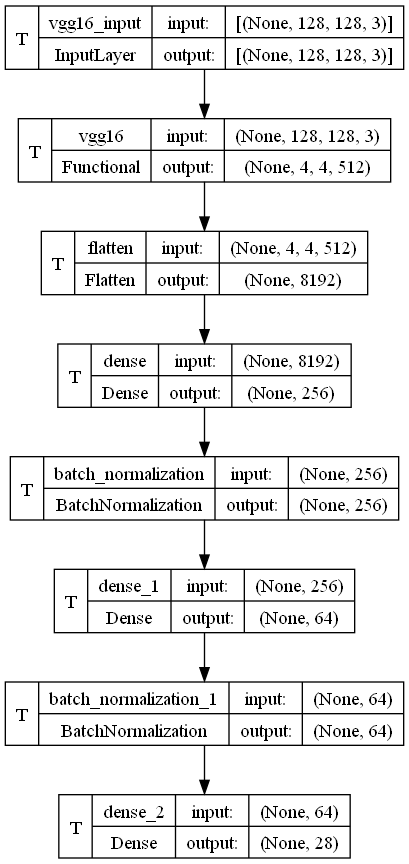

In [14]:
plot_model(model_cnn, show_shapes = True, show_trainable = True)

In [15]:
hist_cnn = model_cnn.fit(train_generator, validation_data = validation_generator, epochs = EPOCHS)

Epoch 1/10
1180/1180 [==============================] - 402s 336ms/step - loss: 0.1510 - accuracy: 0.9704 - val_loss: 0.2317 - val_accuracy: 0.9329
Epoch 2/10
1180/1180 [==============================] - 123s 104ms/step - loss: 0.0330 - accuracy: 0.9925 - val_loss: 0.1484 - val_accuracy: 0.9549
Epoch 3/10
1180/1180 [==============================] - 122s 104ms/step - loss: 0.0186 - accuracy: 0.9959 - val_loss: 0.1915 - val_accuracy: 0.9482
Epoch 4/10
1180/1180 [==============================] - 122s 103ms/step - loss: 0.0120 - accuracy: 0.9970 - val_loss: 0.0980 - val_accuracy: 0.9717
Epoch 5/10
1180/1180 [==============================] - 122s 103ms/step - loss: 0.0088 - accuracy: 0.9978 - val_loss: 0.0774 - val_accuracy: 0.9797
Epoch 6/10
1180/1180 [==============================] - 122s 103ms/step - loss: 0.0057 - accuracy: 0.9985 - val_loss: 0.0874 - val_accuracy: 0.9759
Epoch 7/10
1180/1180 [==============================] - 125s 106ms/step - loss: 0.0048 - accuracy: 0.9988 - val_

Maximum Accuracy of Training set: 0.99960250
Minimum Loss of Trainig set: 0.00204754

Maximum Accuracy of Validation set: 0.97969663
Minimum Loss of Validation set: 0.07736243



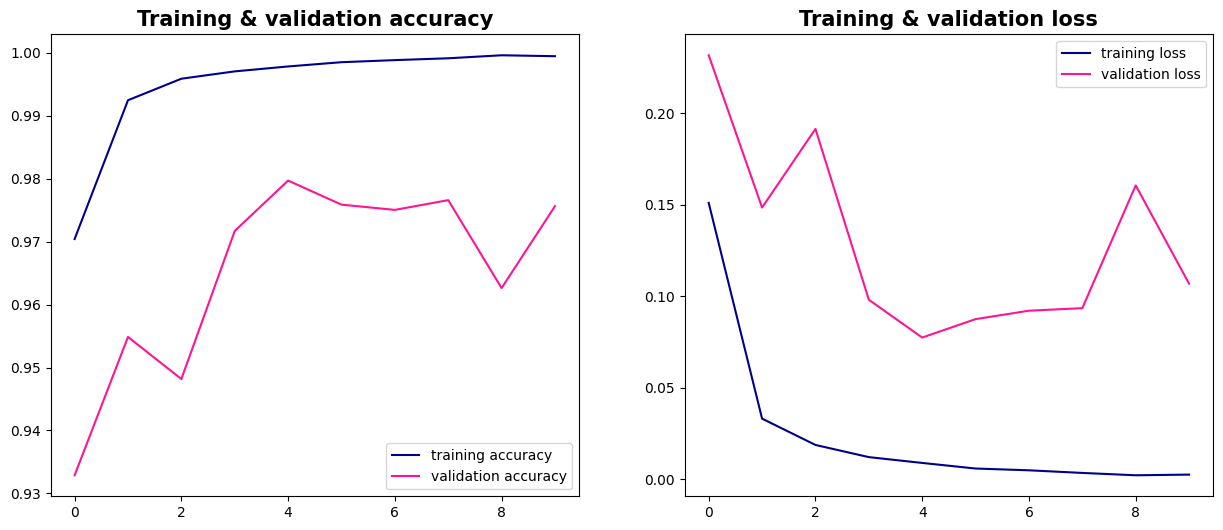

In [16]:
draw_plot(hist_cnn)

In [17]:
model_cnn.compile(optimizer = Adamax(LR_FT), loss = LOSS, metrics = METRICS)

In [18]:
total_epochs = EPOCHS + FINE_TUNE_EPOCHS

hist_cnn_fine = model_cnn.fit(train_generator, 
                              validation_data = validation_generator, 
                              epochs = total_epochs, 
                              initial_epoch = hist_cnn.epoch[-1])

Epoch 10/15
1180/1180 [==============================] - 124s 104ms/step - loss: 9.6648e-04 - accuracy: 0.9999 - val_loss: 0.0822 - val_accuracy: 0.9812
Epoch 11/15
1180/1180 [==============================] - 122s 103ms/step - loss: 7.6310e-04 - accuracy: 0.9999 - val_loss: 0.0805 - val_accuracy: 0.9818
Epoch 12/15
1180/1180 [==============================] - 122s 104ms/step - loss: 6.4975e-04 - accuracy: 0.9999 - val_loss: 0.0790 - val_accuracy: 0.9823
Epoch 13/15
1180/1180 [==============================] - 123s 104ms/step - loss: 5.6341e-04 - accuracy: 1.0000 - val_loss: 0.0781 - val_accuracy: 0.9829
Epoch 14/15
1180/1180 [==============================] - 122s 104ms/step - loss: 5.3719e-04 - accuracy: 1.0000 - val_loss: 0.0782 - val_accuracy: 0.9828
Epoch 15/15
1180/1180 [==============================] - 123s 104ms/step - loss: 4.9528e-04 - accuracy: 1.0000 - val_loss: 0.0777 - val_accuracy: 0.9829


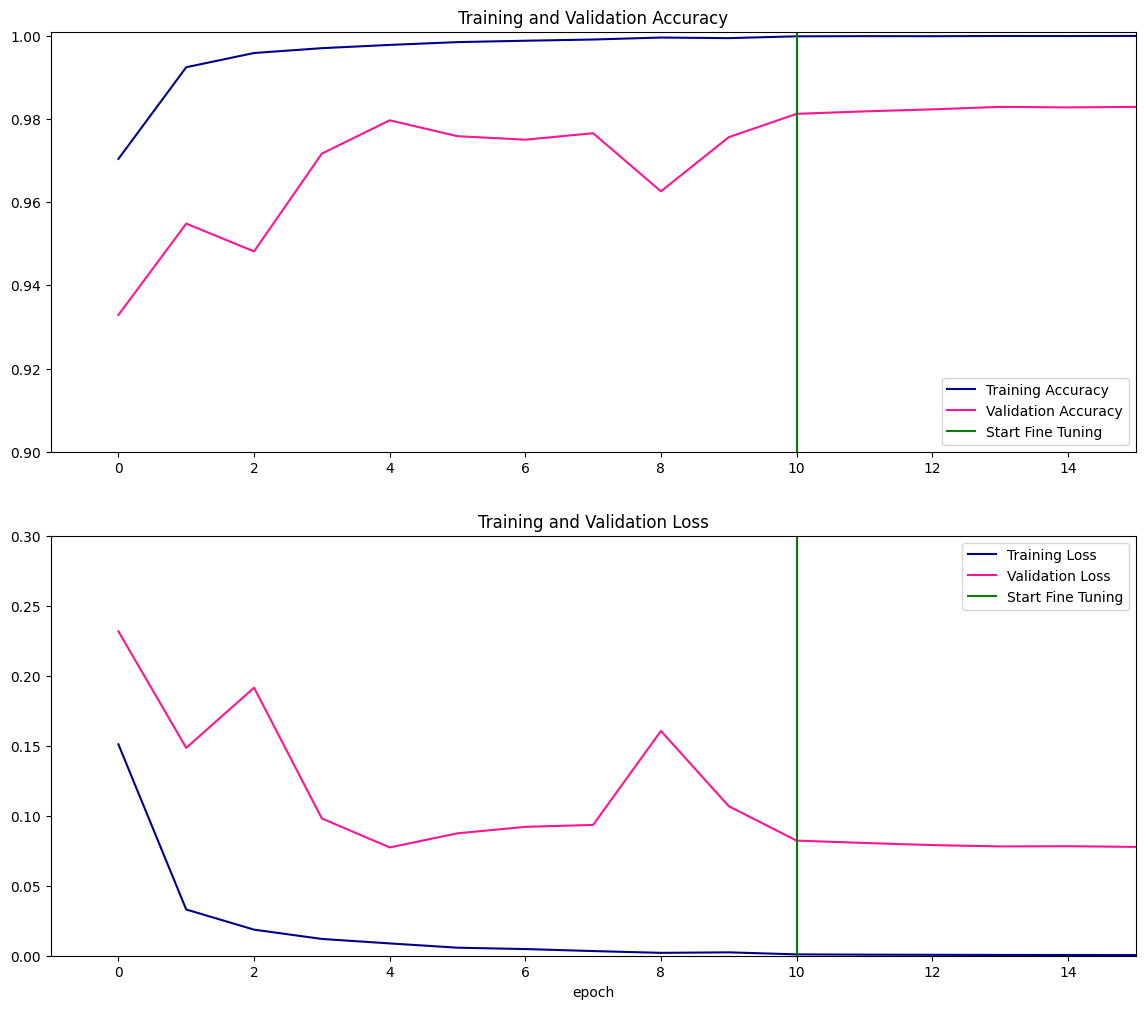

In [19]:
draw_plot_fine(hist_cnn, hist_cnn_fine)

## Evaluation

In [20]:
loss, accuracy = model_cnn.evaluate(validation_generator)
print('Test accuracy :', accuracy * 100)

131/131 [==============================] - 11s 82ms/step - loss: 0.0777 - accuracy: 0.9829
Test accuracy : 98.2921302318573


## Save Model

In [22]:
model_cnn.save('model_cnn.keras')